In [1]:
import mindspore

# mindspore.dataset
import mindspore.dataset as ds # Dataset loading.
import mindspore.dataset.transforms.c_transforms as C # Common conversion operators. 
import mindspore.dataset.vision.c_transforms as CV # Image conversion operator.

# mindspore.common
from mindspore.common import dtype as mstype # Data form conversion. 
from mindspore.common.initializer import Normal # Parameter initialization.

# mindspore.nn
import mindspore.nn as nn # Includes all network layers.
from mindspore.nn.metrics import Accuracy, Loss # Used for testing models.

# mindspore.train.callback
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback # callback functions.

from mindspore import Model # Bears the network structure.
from mindspore import save_checkpoint, load_checkpoint # Saves and reads the optimal parameters. 
from mindspore import context # Sets the MindSpore running environment.

from mindspore.ops import operations as P
from mindspore.ops import functional as F
from mindspore.common.tensor import Tensor


import numpy as np # numpy
import matplotlib.pyplot as plt # Visualization. 
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei' # Chinese display
import copy # Used to save network parameters.

# Data path processing 
import os, stat

import json
import math

In [2]:
device_target = context.get_context('device_target') # Obtain the running device (CPU, GPU, or Ascend).
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # Indicates whether to deliver data to the device through the pipeline.
context.set_context(mode = context.GRAPH_MODE, device_target = device_target)
# Set the running environment. The static graph context.GRAPH_MODE points to the static graph model. That is, all graphs are created and built before the running.

print(f'device_target: {device_target}') 
print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: CPU
dataset_sink_mode: False


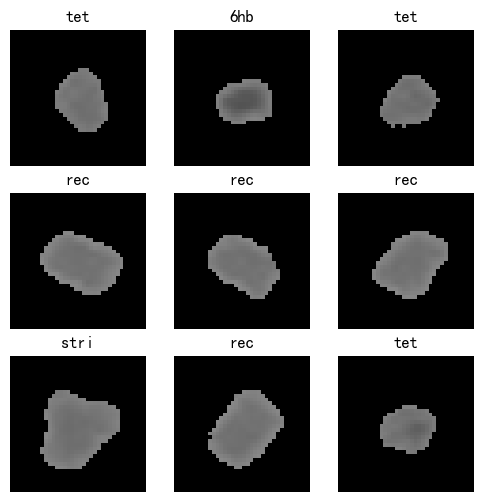

In [3]:
class_dict = {'0':'6hb','1':'rec','2':'stri','3':'tet','4':'tri'}

dataset_dir = "./data"
train_path = "./data/train"
test_path = "./data/test"

demo = ds.ImageFolderDataset(test_path,decode=True)

# Set the image size. 
plt.figure(figsize=(6, 6))

# Print nine subgraphs. 
i = 1

for dic in demo.create_dict_iterator(): 
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy()) # asnumpy: converts a MindSpore tensor to a NumPy tensor. 
    plt.axis('off')
    plt.title(class_dict[str(dic['label'].asnumpy())]) 
    i +=1
    if i > 9 :
        break

plt.show()

In [4]:
ds_train = ds.ImageFolderDataset(train_path,decode=True)
# Compute the average value and standard deviation of the dataset, which are used for data normalization.
tmp = [] 
for x in ds_train.create_dict_iterator(output_numpy=True):
    tmp.append(x['image'].astype(np.float32))
tmp = np.array(tmp)
RGB_mean = tuple(np.mean(tmp,axis=(0,1,2)))
RGB_std = tuple(np.std(tmp,axis=(0,1,2)))

print(RGB_mean) 
print(RGB_std)

(22.015188, 22.015188, 22.015188)
(46.304188, 46.304188, 46.304188)


In [5]:
def create_dataset(data_path, batch_size = 32, repeat_num=1, usage = 'train'): 
    """
    Process data.

    Args:
    data_path (str): data path batch_size (int): batch size usage (str): training or test

    Returns:
    Dataset object
    """
    # Load the dataset.
    data = ds.ImageFolderDataset(data_path,decode=True)

    # Shuffle the dataset.
    data = data.shuffle(buffer_size=10000)

    # Define an operator. 
    if usage=='train':
        trans = [
        CV.Normalize(RGB_mean, RGB_std), # Normalize data.

        # Data augmentation
        CV.Resize([32,32]),
        CV.RandomCrop( [32, 32], [4, 4, 4, 4]), # Random cropping 
        CV.RandomHorizontalFlip(), # Random flipping

        CV.HWC2CHW() # Channel moved forward. (To adapt to the network, the CHW format can best utilize the computing power of the Ascend chip.)
        ]
    else:
        trans = [
        CV.Normalize(RGB_mean, RGB_std), # Normalize data.
        CV.Resize([32,32]),
        CV.HWC2CHW() # Channel moved forward. (To adapt to the network, the CHW format can best utilize the computing power of the Ascend chip.)
        ]
    
    typecast_op = C.TypeCast(mstype.int32) # The label of the original data is unint. To compute the loss, int is required.

    # Operator computation
    data = data.map(input_columns='label', operations=typecast_op) 
    data = data.map(input_columns='image', operations=trans)

    # Batch processing
    data = data.batch(batch_size, drop_remainder=True)

    # Repeat.
    data = data.repeat(repeat_num)

    return data



In [6]:
class LeNet5(nn.Cell): 
    """
    LeNet5

    Args:
    num_class (int): number of output classes 
    num_channel (int): number of input channels
    Returns:
    Output tensor

    Examples:
    >>> LeNet5(10, 3)
    """

    # Define an operator.
    def __init__(self, num_class=10, num_channel=3): 
        super(LeNet5, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')

        # Fully connected layer
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02)) 
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02)) 
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))

        # Activation function 
        self.relu = nn.ReLU()

        # Maximum pooling layer
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten the network. 
        self.flatten = nn.Flatten()

    # Build the network. 
    def construct(self, x): 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x) 
        x = self.flatten(x)
        x = self.fc1(x) 
        x = self.relu(x) 
        x = self.fc2(x) 
        x = self.relu(x) 
        x = self.fc3(x)
        return x



In [7]:
train_data = create_dataset(train_path, batch_size = 32, usage = 'train') # Training dataset
test_data = create_dataset(test_path, batch_size = 50, usage= 'test') # Test dataset

[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:48:10.850.159 [mindspore\dataset\core\validator_helpers.py:744] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:48:10.851.165 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:48:10.851.680 [mindspore\dataset\core\validator_helpers.py:744] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:48:10.852.691 [mindspore\dataset\core\validator_helpers.py

In [8]:
# Network
network1 = LeNet5(5)

# Loss function
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# Optimizer
net_opt = nn.Momentum(params=network1.trainable_params(), learning_rate=0.01, momentum=0.9)

# Model
model = Model(network = network1, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss':Loss()})


In [9]:
# Record the loss of each epoch in the model. 
class TrainHistroy(Callback):
    """
    Record the loss callback function of each epoch during model training.

    Args:
    history (list): inputs a list to save the loss of each epoch of the model.
    """

    def __init__(self, history): 
        super(TrainHistroy, self).__init__() 
        self.history = history

    # Run it when each epoch ends. 
    def epoch_end(self, run_context):
        cb_params = run_context.original_args() 
        loss = cb_params.net_outputs.asnumpy() 
        self.history.append(loss)


    # Test and record the loss and accuracy of the model in the test set. After each epoch ends, perform the model test and record the result. Trace and save the network parameters of the model with the highest accuracy.
class EvalHistory(Callback): 
    """
    Record the loss and accuracy callback functions of each epoch in the test set during model training, and save the model network parameters with the highest accuracy.

    Args:
    model (Cell): model for loss and accuracy evaluation
    loss_history (list): inputs a list to save the loss of each epoch of the model in the test set. acc_history (list): inputs a list to save the accuracy of each epoch of the model in the test set. eval_data (Dataset): test set, which is used to evaluate the loss and accuracy of the model.
    """

    # Save the network parameters with the highest accuracy. 
    best_param = None

    def __init__(self, model, loss_history, acc_history, eval_data): 
        super(EvalHistory, self).__init__()
        self.loss_history = loss_history 
        self.acc_history = acc_history 
        self.eval_data = eval_data 
        self.model = model

    # Run it when each epoch ends. 
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)

        if len(self.acc_history)==0 or res['accuracy']>=max(self.acc_history): 
            self.best_param = copy.deepcopy(cb_params.network)

        self.loss_history.append(res['loss']) 
        self.acc_history.append(res['accuracy'])

        print('acc_eval: ',res['accuracy'])

    # Run the following command after the training is complete:
    def end(self, run_context):
        # Save the optimal network parameters.
        ckpt_path = os.path.join('.','results')
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')

        if os.path.exists(best_param_path):
        # If best_param.ckpt already exists, MindSpore will overwrite the old file. Modify the read and write permissions of the file to prevent errors.
            os.chmod(best_param_path, stat.S_IWRITE)

        save_checkpoint(self.best_param, best_param_path)


In [10]:
ckpt_path = os.path.join('.','results') # Path for saving network parameters 
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # Training process record

# The network parameters are automatically saved. In this example, the network parameters are saved every 2000 steps and they can be saved for a maximum of 10 times.
config_ck = CheckpointConfig(save_checkpoint_steps=2000,keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet', directory=ckpt_path, config=config_ck)

# Monitor the time of each step.
ds_train = ds.ImageFolderDataset(train_path,decode=True)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

# Monitor the loss value.
loss_cb = LossMonitor(per_print_times=500)

# Record the model loss value of each step. 
train_hist_cb = TrainHistroy(hist['loss'])

# Test and record the loss and accuracy of the model in the validation set, and save the optimal network parameters.
eval_hist_cb = EvalHistory(model = model,
loss_history = hist['loss_eval'],
acc_history = hist['acc_eval'], eval_data = test_data)


In [11]:
epoch = 100 # Number of epochs 
# Start training.
model.train(epoch, train_data, callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, loss_cb], dataset_sink_mode=dataset_sink_mode)


[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:48:53.829.314 [mindspore\train\model.py:1099] For TrainHistroy callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:48:53.830.327 [mindspore\train\model.py:1099] For EvalHistory callback, {'epoch_end', 'end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


acc_eval:  0.35
Train epoch time: 1403.238 ms, per step time: 18.464 ms
acc_eval:  0.34833333333333333
Train epoch time: 748.710 ms, per step time: 9.851 ms
acc_eval:  0.6466666666666666
Train epoch time: 707.078 ms, per step time: 9.304 ms
acc_eval:  0.675
Train epoch time: 738.022 ms, per step time: 9.711 ms
acc_eval:  0.59
Train epoch time: 705.676 ms, per step time: 9.285 ms
acc_eval:  0.5383333333333333
Train epoch time: 726.246 ms, per step time: 9.556 ms
epoch: 7 step: 44, loss is 0.8808150887489319
acc_eval:  0.6616666666666666
Train epoch time: 724.756 ms, per step time: 9.536 ms
acc_eval:  0.695
Train epoch time: 733.988 ms, per step time: 9.658 ms
acc_eval:  0.55
Train epoch time: 723.226 ms, per step time: 9.516 ms
acc_eval:  0.6616666666666666
Train epoch time: 730.795 ms, per step time: 9.616 ms
acc_eval:  0.6683333333333333
Train epoch time: 712.479 ms, per step time: 9.375 ms
acc_eval:  0.645
Train epoch time: 727.281 ms, per step time: 9.569 ms
acc_eval:  0.71166666666

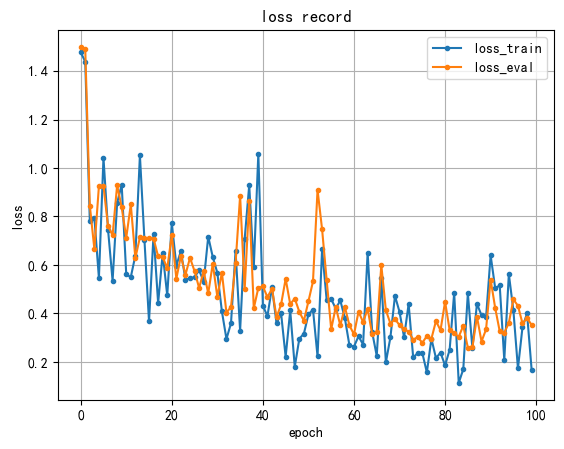

In [12]:
# Define the loss record drawing function. 
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.') 
    plt.plot(hist['loss_eval'], marker='.') 
    plt.title('loss record')
    plt.xlabel('epoch') 
    plt.ylabel('loss') 
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right') 
    plt.show()
    plt.close()

plot_loss(hist)

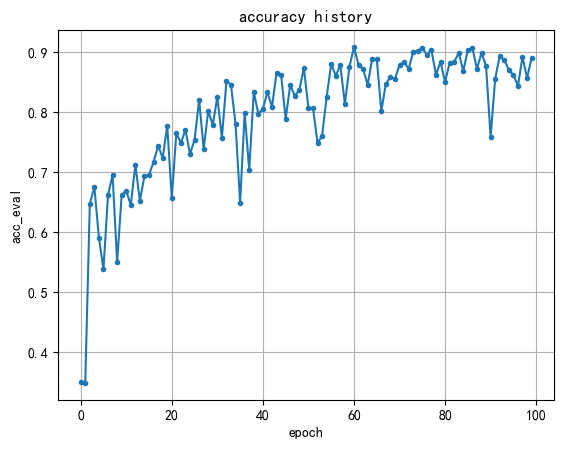

In [13]:
def plot_accuracy(hist): 
    plt.plot(hist['acc_eval'], marker='.') 
    plt.title('accuracy history') 
    plt.xlabel('epoch') 
    plt.ylabel('acc_eval')
    plt.grid() 
    plt.show() 
    plt.close()

plot_accuracy(hist)

In [14]:
# Use the most accurate parameter combination to build a model and test its effect on the validation set.
load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network1)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode) 
print(res)


{'accuracy': 0.9066666666666666, 'loss': 0.3168685883283615}


[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:50:27.136.365 [mindspore\dataset\core\validator_helpers.py:744] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:50:27.136.365 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:50:27.137.371 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(22976:43564,MainProcess):2023-11-09-16:50:27.138.369 [mindspore\dataset\core\validator_helpers.py:744] 

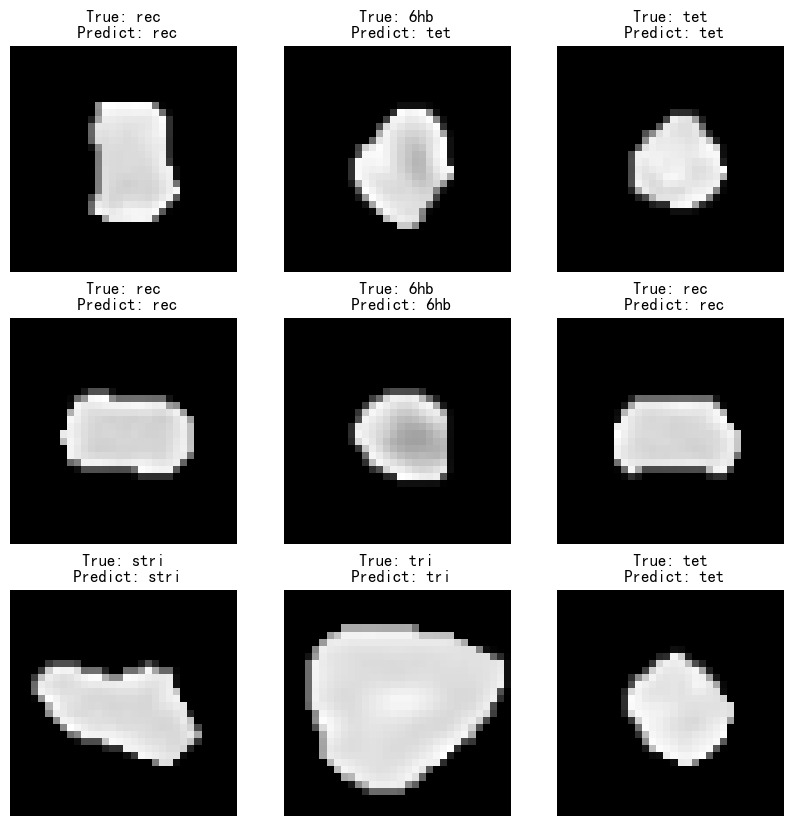

In [15]:
demo_data = create_dataset(test_path, batch_size=1, usage='test') 

# Standardize the data to the range from 0 to 1.
def normalize(data):
    _range = np.max(data) - np.min(data) 
    return (data - np.min(data)) / _range

# Set the image size. 
plt.figure(figsize=(10,10)) 
i = 1

# Print nine subgraphs.
for dic in demo_data.create_dict_iterator(): 
    # Predict a single image.
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # Returns a class with the highest possibility.

    # Visualization 
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0) # The batch dimension is deleted to facilitate visualization.
    input_image = input_image.transpose(1,2,0) # Changes CHW to HWC, facilitating visualization. 
    input_image = normalize(input_image) # Perform normalization again to facilitate visualization. 
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s' %(class_dict[str(dic['label'].asnumpy().item())],class_dict[str(predict)]) )
    i += 1
    if i > 9:
        break

plt.show()
    
